In [2]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import folium
import json
#from ipywidgets import IntSlider, interact
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.decomposition import PCA
from scipy import stats
from sklearn import preprocessing
import math

In [718]:
#Load the emissions data set
total_emissions = pd.read_csv('./data/Emissions_AllAgriculture.csv', sep=',', encoding = 'latin-1')
total_emissions.columns = ('domain_code', 'domain', 'area_code','area', 'element_code','element','item_code', 'item','year_code','year','unit','value','flag', 'flag_description','note')
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1962,1962,gigagrams,5151.5228,A,"Aggregate, may include official, semi-official...",NaN


In [719]:
#load the area dataset to use for normalization
total_area=pd.read_csv('./data/LandUse.csv',sep=',',encoding='latin-1')
total_area_agriculture = total_area.query("Item == 'Agriculture'")
total_area_agriculture.head(2)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
114,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1961,1961,1000 ha,37700.0,Fc,Calculated data
115,RL,Land Use,2,Afghanistan,5110,Area,6602,Agriculture,1962,1962,1000 ha,37760.0,Fc,Calculated data


In [720]:
#first join the area and emissions datasets
total_emissions = pd.merge(total_emissions, total_area_agriculture.loc[:,['Value', 'Area','Year']], left_on = ['area','year'], right_on = ['Area','Year'])
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961


In [721]:
#next normalize based on area
total_emissions['emissions_ha'] = total_emissions.value / total_emissions.Value
total_emissions.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757


In [722]:
#let's check for missing values
missing_total = total_emissions[total_emissions.emissions_ha ==0].shape
total = total_emissions.shape
percent = (missing_total[0] / total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(total[0], missing_total[0], percent))

There are 92067 values with 3157 equal to 0 which is 3 percent


In [723]:
#since we are only concerned with the fertilizer emissions, let's check how many of these are in fertilizer
emissions_fertilizer = total_emissions.query("item == 'Synthetic Fertilizers'")

emissions_missing = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
emissions_total = emissions_fertilizer.shape
percent_emissions = (emissions_missing[0] / emissions_total[0])*100

print('There are %d values with %d equal to 0 which is %d percent'%(emissions_total[0], emissions_missing[0], percent_emissions))

There are 10043 values with 1153 equal to 0 which is 11 percent


In [724]:
#let's see where these missing values are coming from (which country, which years)
emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].groupby('year').count().sort_values('item', ascending = False)


,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
year,,,,,,,,,,,,,,,,,,
1961,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1962,46,46,46,46,46,46,46,46,46,46,46,46,0,0,46,46,46,46
1963,45,45,45,45,45,45,45,45,45,45,45,45,0,0,45,45,45,45
1964,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1965,43,43,43,43,43,43,43,43,43,43,43,43,0,0,43,43,43,43
1966,40,40,40,40,40,40,40,40,40,40,40,40,0,0,40,40,40,40
1967,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1968,38,38,38,38,38,38,38,38,38,38,38,38,0,0,38,38,38,38
1969,36,36,36,36,36,36,36,36,36,36,36,36,0,0,36,36,36,36


We can see that the number of missing values is dramatically lower from 2002 on and not too significant in any given year. We will drop the missing values and our focus will mostly focus from 2002 onwards anyways since this is when we have other fertilizer data from.

In [729]:
total_emissions.head()

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
0,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5058,Enteric Fermentation,1961,1961,gigagrams,5054.3459,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.134068
1,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5059,Manure Management,1961,1961,gigagrams,367.8310,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.009757
2,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5060,Rice Cultivation,1961,1961,gigagrams,617.4000,Fc,Calculated data,NaN,37700.0,Afghanistan,1961,0.016377
3,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1961,1961,gigagrams,6.4546,EA,NaN,NaN,37700.0,Afghanistan,1961,0.000171
4,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5062,Manure applied to Soils,1961,1961,gigagrams,390.4421,A,"Aggregate, may include official, semi-official...",NaN,37700.0,Afghanistan,1961,0.010357


In [730]:
total_emissions = total_emissions[(total_emissions['emissions_ha'] != 0)]
emissions_fertilizer = emissions_fertilizer[(emissions_fertilizer['emissions_ha'] != 0)]

In [11]:
missing_2 = emissions_fertilizer[emissions_fertilizer.emissions_ha ==0].shape
print('There are %d values equal to 0'%(missing_2[0]))

There are 0 values equal to 0


Now let's take a look at the distribution of the data:

(array([8.876e+03, 0.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00]),
 array([9.62463908e-08, 2.40348920e+01, 4.80697839e+01, 7.21046757e+01,
        9.61395676e+01, 1.20174460e+02, 1.44209351e+02, 1.68244243e+02,
        1.92279135e+02, 2.16314027e+02, 2.40348919e+02]),
 <a list of 10 Patch objects>)

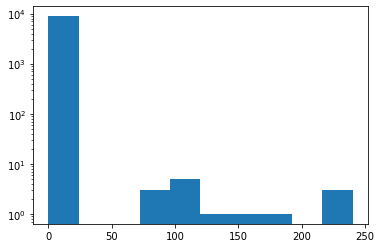

In [11]:
plt.hist(emissions_fertilizer.emissions_ha, log = True)

In [12]:
#now let's read the crops dataset
crops=pd.read_pickle("crops_interpolated")

In [13]:
# To avoid duplicated index or other index issues
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


In [14]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_class(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [519]:
# This function separate countries in three different groups according to their fertilizer emissions
def emissions_color(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 'green'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'yellow'
    else:
        return 'red'

In [764]:

def umap_year_emissions(year, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .query('`Area Code` <300') # Exclusion of grouped areas
            .pivot(index='Area',columns='Item',values='Value')
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
            .reset_index()
            
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    #importation of emissions
    umap_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    embedding2=pd.merge(embedding2,umap_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    
    #Result normalization to be able to compare them between years
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2.rename(columns={0: "Umap"}, inplace=True)
    embedding2['emissions_ha']=(embedding2['emissions_ha']-min(embedding2['emissions_ha']))/(max(embedding2['emissions_ha'])-min(embedding2['emissions_ha']))
    embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
    
    coef = np.polyfit(embedding2['Umap'],embedding2.emissions_ha,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

Text(0, 0.5, 'Interpolation Coef')

<Figure size 1440x1080 with 0 Axes>

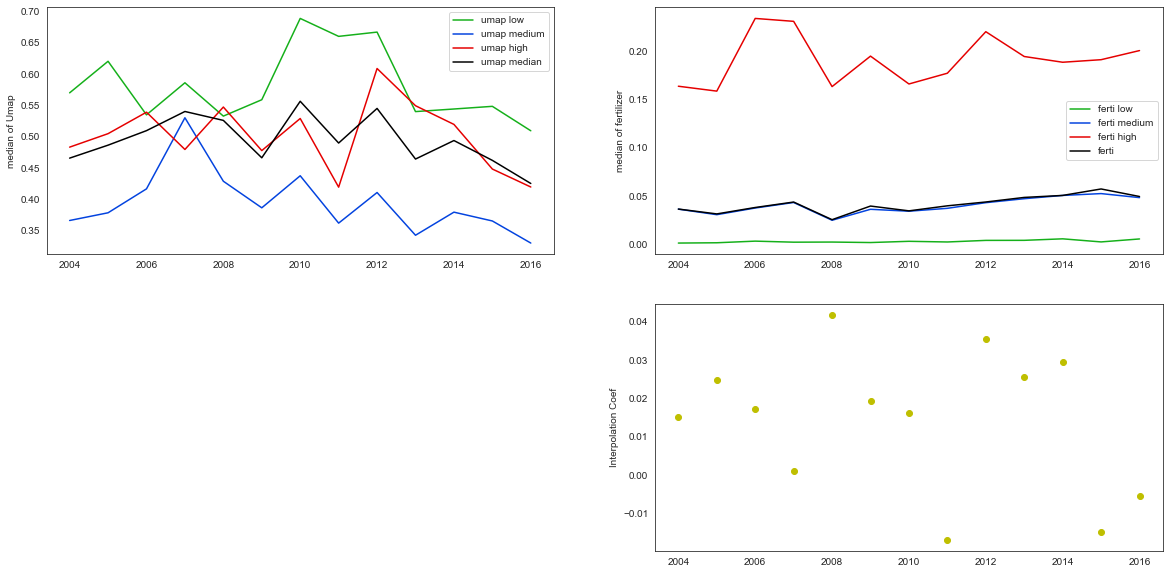

In [765]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)

umap_plot=[]
for year in range(2004, 2017):
    umap_result=umap_year_emissions(year,1)
    low_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='low'].median()
    medium_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='medium'].median()
    high_median=umap_result[1].emissions_ha[umap_result[1].emissions_class=='high'].median()
    ferti_median=umap_result[1].emissions_ha.median()
    
    umap_low_median=umap_result[1].Umap[umap_result[1].emissions_class=='low'].median()
    umap_medium_median=umap_result[1].Umap[umap_result[1].emissions_class=='medium'].median()
    umap_high_median=umap_result[1].Umap[umap_result[1].emissions_class=='high'].median()
    umap_median=umap_result[1].Umap.median()
    
    umap_plot.append([umap_result[0],umap_result[2][0],low_median,medium_median,high_median,ferti_median,
                         umap_low_median,umap_medium_median,umap_high_median,umap_median])
    
umap_plot=pd.DataFrame(umap_plot, 
                          columns= ['Year','Coef','ferti low','ferti medium','ferti high','ferti',
                                          'umap low','umap medium','umap high','umap median'])

colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("Year", "umap low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax1.plot("Year", "umap medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax1.plot("Year", "umap high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax1.plot("Year", "umap median", data=umap_plot, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of Umap')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("Year", "ferti low", data=umap_plot, color=sns.xkcd_palette(colors)[0])
ax2.plot("Year", "ferti medium", data=umap_plot, color=sns.xkcd_palette(colors)[1])
ax2.plot("Year", "ferti high", data=umap_plot, color=sns.xkcd_palette(colors)[2])
ax2.plot("Year", "ferti", data=umap_plot, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax4 = figure.add_subplot(2,2,4)
ax4.plot("Year", 'Coef', 'yo', data=umap_plot)
ax4.set_ylabel('Interpolation Coef')

In [768]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [378]:
crops.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900,F


In [771]:
#pca for 1 year:
grouped_yield=crops.query('`Element Code` == 5419')\
.query('`Year Code` == 2016')\
.query('`Item Code` >1000')\
.query('`Area Code` <300')\
.pivot(index='Area',columns='Item',values='Value')\
.drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
.reset_index()


grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
grouped_yield=grouped_yield.dropna(axis=0)
grouped_yield=grouped_yield.reindex()

emissions_fert_2016 = emissions_fertilizer.query("year == 2016")

pca,pca_one = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
pca_one=pd.merge(pca_one,emissions_fert_2016.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
pca_one['emissions_class']=pca_one.emissions_ha.apply(lambda x: emissions_class(x, pca_one.emissions_ha))


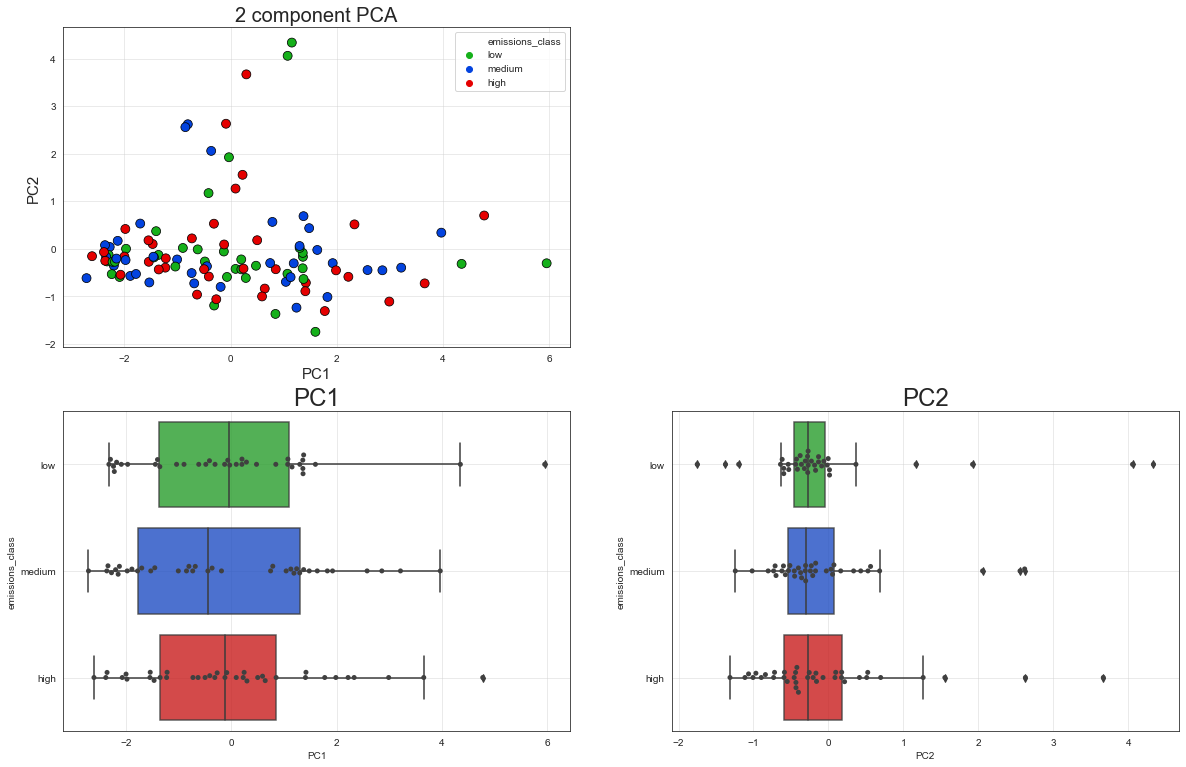

In [773]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='emissions_class', palette=sns.xkcd_palette(colors), data=pca_one, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='emissions_class', data=pca_one, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='emissions_class', data=pca_one, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='emissions_class', data=pca_one, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='emissions_class', data=pca_one, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

In [382]:
grouped_yield.head()

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Coarse Grain, Total",Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Vegetables Primary
0,Afghanistan,19391,19816,16667,88201,6868.33,4060.16,7406,119868,91869
1,Albania,47164,47164,54585,225650,8590.25,6390.75,13178,245894,272656
2,Algeria,10204,10204,7647,105776,10673,3412.9,9978,304431,219122
3,American Samoa,NaN,NaN,NaN,41581,2332.37,3790.24,NaN,38299,37544
4,Angola,9263,9341,9248,221661,2415.01,2342.51,4858,103597,37260


In [105]:
def PCA_year_emissions(year):

    grouped_yield=crops.query('`Element Code` == 5419')\
    .query('`Year Code` == @year')\
    .query('`Item Code` >1000')\
    .query('`Area Code` <300')\
    .pivot(index='Area',columns='Item',values='Value')\
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
    .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reindex()
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])

    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))

    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    grouped_yield_pca.emissions_ha=(grouped_yield_pca.emissions_ha-min(grouped_yield_pca.emissions_ha))/(max(grouped_yield_pca.emissions_ha)-min(grouped_yield_pca.emissions_ha))
    
    
    
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1)

    return year,grouped_yield_pca,coef # return year (for confirmation), performed PCA and value of linear regression

In [782]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
emissions_low = []
emissions_medium = []
emissions_high = []
emissions = []
emissions_effect = []
proportion_explained = []
test = []


for year in range(2002,2016):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
        .query('`Year Code` == @year')\
        .query('`Item Code` >1000')\
        .query('`Area Code` <300')\
        .pivot(index='Area',columns='Item',values='Value')\
        .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])\
        .reset_index()

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    #importation of emissions
    pca_emissions=(emissions_fertilizer
                    .query('Year == @year'))
    
    grouped_yield_pca=pd.merge(grouped_yield_pca,pca_emissions.loc[:,['Area','emissions_ha']],left_on='Area',right_on='Area')
    grouped_yield_pca['emissions_class']=grouped_yield_pca.emissions_ha.apply(lambda x: emissions_class(x, grouped_yield_pca.emissions_ha))
    
    PC1_low += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='low'].median()]
    PC1_medium += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='medium'].median()]
    PC1_high += [grouped_yield_pca.PC1[grouped_yield_pca.emissions_class=='high'].median()]
    PC1 += [grouped_yield_pca.PC1.median()]
    #test += [grouped_yield_pca.PC1.median()/emissions_ha.median()]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    emissions_low += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='low'].median()]
    emissions_medium += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='medium'].median()]
    emissions_high += [grouped_yield_pca.emissions_ha[grouped_yield_pca.emissions_class=='high'].median()]
    
    emissions += [grouped_yield_pca.emissions_ha.median()]
    
    grouped_yield_pca.dropna(axis=0, inplace=True)
    grouped_yield_pca.PC1=(grouped_yield_pca.PC1-min(grouped_yield_pca.PC1))/(max(grouped_yield_pca.PC1)-min(grouped_yield_pca.PC1))
    
    emissions_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.emissions_ha,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

Text(0, 0.5, 'emissions effect')

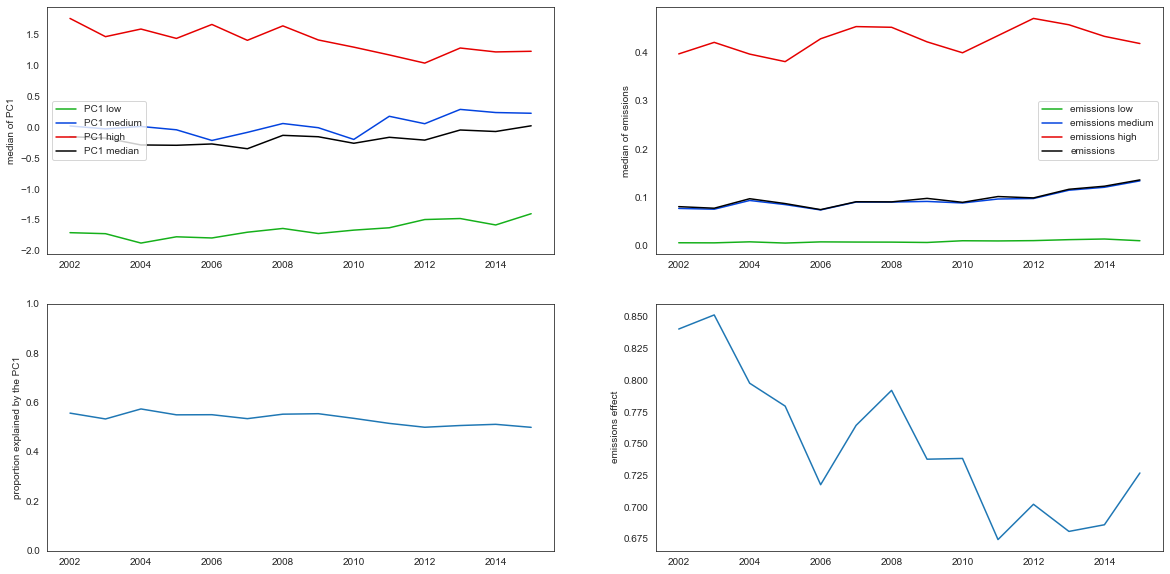

In [785]:
evolution_emissions = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, emissions_medium, emissions_high,emissions,PC1, proportion_explained, emissions_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','emissions low', 'emissions medium', 'emissions high','emissions','PC1 median', 'proportion explained', 'emissions effect']).T
colors = ["green", "blue", "red"]

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend(loc = 'center left')

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "emissions low", data=evolution_emissions, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "emissions medium", data=evolution_emissions, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "emissions high", data=evolution_emissions, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "emissions", data=evolution_emissions, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of emissions')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_emissions)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'emissions effect', data=evolution_emissions)
ax4.set_ylabel('emissions effect')

In [121]:
emissions_fertilizer.head(2)

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
3,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1961,1961,gigagrams,6.4546,EA,NaN,NaN,37700.0,Afghanistan,1961,0.000171
11,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1962,1962,gigagrams,6.4546,EA,NaN,NaN,37760.0,Afghanistan,1962,0.000171


In [786]:
#emissions dataframe
emissions_year=pd.DataFrame(columns=['area'])
years = np.array([range(2002,2018)]).astype(str)

for year in range(2002,2018):#emissions_fertilizer.pivot_table(index=['year_code']).index :
    emissions=(emissions_fertilizer
            .query('`year_code` == @year')
            .pivot(index='area',columns = 'year_code',values='emissions_ha')
            .dropna(axis=0)
            .reset_index()
              )
    emissions.dropna(axis=0, inplace=True)
    emissions_year=emissions.merge(emissions_year, on='area',how='outer')

emissions_year.dropna(inplace = True)
emissions_year.columns = emissions_year.columns.astype(str)
emissions_year.head(2)

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383


In [787]:
emissions_year_2 = emissions_year.T
emissions_year_2.rename(columns=emissions_year_2.iloc[0], inplace = True)
emissions_year_2.drop(emissions_year_2.index[0], inplace = True)
emissions_year_2.dropna(axis = 'columns', inplace = True)
emissions_year_2.sort_index(inplace = True)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.0041928,0.216383,0.00454052,0.00031008,0.0268091,0.0728526,0.0141526,0.380255,0.0214266,0.580533,...,0.430031,0.00418835,0.171031,0.0112449,0.133408,0.0569351,0.775278,0.00308326,0.0115117,0.0295161
2003,0.00347454,0.215222,0.002762,0.000200285,0.0365263,0.0467112,0.0137009,0.668554,0.0170862,1.64415,...,0.428254,0.00500814,0.180292,0.0285039,0.134307,0.0575344,0.840039,0.00135109,0.0120635,0.0319635


## Data frame for fertilizer emissions over the years per country:

In [17]:
emissions_year_2.dropna(axis = 'columns', inplace = True)
emissions_year_2.sort_index(inplace = True)
emissions_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahrain,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,0.0041928,0.216383,0.00454052,0.00031008,0.0268091,0.0728526,0.0141526,0.380255,0.0214266,0.580533,...,0.430031,0.00418835,0.171031,0.0112449,0.133408,0.0569351,0.775278,0.00308326,0.0115117,0.0295161
2003,0.00347454,0.215222,0.002762,0.000200285,0.0365263,0.0467112,0.0137009,0.668554,0.0170862,1.64415,...,0.428254,0.00500814,0.180292,0.0285039,0.134307,0.0575344,0.840039,0.00135109,0.0120635,0.0319635


Text(0.5, 0, 'Year')

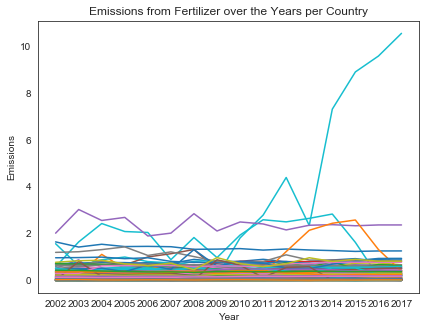

In [788]:
figure = plt.figure(figsize = (15,5))
ax1 = figure.add_subplot(1,2,1)


for x in range(0, emissions_year_2.shape[1]):
    ax1.plot(emissions_year_2.index, emissions_year_2.iloc[:,x])

ax1.set_title('Emissions from Fertilizer over the Years per Country')
ax1.set_ylabel('Emissions')
ax1.set_xlabel('Year')

In [64]:
emissions_year[emissions_year['2016'] > 2]

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
34,"China, Hong Kong SAR",10.542040,9.573560,8.896667,7.308961,2.346392,4.393059,2.788400,1.814345,0.163517,0.426000,0.749817,0.804683,0.998629,0.882443,0.622414,1.566629
51,Egypt,2.367983,2.367983,2.332931,2.379826,2.355047,2.155582,2.410167,2.495033,2.109501,2.847678,2.018415,1.897071,2.689774,2.558832,3.026404,2.017144


In [346]:
emissions_year_class = emissions_year.copy().set_index('area')
emissions_year_class['mean'] = emissions_year_class.mean(axis = 1)
emissions_year_class['emissions_class'] = emissions_year_class['mean'].apply(lambda x: emissions_class(x, emissions_year_class['mean']))
emissions_year_class.head(2)

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,mean,emissions_class
area,,,,,,,,,,,,,,,,,,
Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193,0.006103,low
Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383,0.193822,medium


In [350]:
emissions_class_df = emissions_year_class.loc[:,['mean','emissions_class']]
emissions_class_df.head(2)

,mean,emissions_class
area,,
Afghanistan,0.006103,low
Albania,0.193822,medium


In [310]:
emissions_low = emissions_year_class.query('emissions_class == "low"')
emissions_low.drop(['emissions_class'], axis = 1, inplace = True)
emissions_low_2 = emissions_low.T
emissions_low_2.rename(columns=emissions_low_2.iloc[0], inplace = True)
emissions_low_2.drop(emissions_low_2.index[0], inplace = True)
emissions_low_2.sort_index(inplace = True)


emissions_medium = emissions_year_class.query('emissions_class == "medium"')
emissions_medium.drop(['emissions_class'], axis = 1, inplace = True)
emissions_medium_2 = emissions_medium.T
emissions_medium_2.rename(columns=emissions_medium_2.iloc[0], inplace = True)
emissions_medium_2.drop(emissions_medium_2.index[0], inplace = True)
emissions_medium_2.sort_index(inplace = True)

emissions_high = emissions_year_class.query('emissions_class == "high"')
emissions_high.drop(['emissions_class'], axis = 1, inplace = True)
emissions_high_2 = emissions_high.T
emissions_high_2.rename(columns=emissions_high_2.iloc[0], inplace = True)
emissions_high_2.drop(emissions_high_2.index[0], inplace = True)
emissions_high_2.sort_index(inplace = True)

/Users/AmaraSlaymaker/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
emissions_low

,area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
2,Algeria,0.010962,0.010955,0.011584,0.011918,0.009971,0.011320,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
3,Angola,0.002912,0.002266,0.002780,0.003011,0.002229,0.002125,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
5,Argentina,0.042359,0.040350,0.026195,0.034035,0.034097,0.031781,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809
7,Australia,0.017874,0.018335,0.020665,0.019915,0.019889,0.017902,0.017314,0.015899,0.013410,0.012916,0.012877,0.012733,0.013808,0.015490,0.013701,0.014153
9,Azerbaijan,0.011714,0.035662,0.005765,0.051366,0.034358,0.037281,0.030471,0.017349,0.026155,0.040261,0.022775,0.027626,0.023839,0.026668,0.017086,0.021427
17,Benin,0.000075,0.023177,0.000302,0.024126,0.008218,0.015382,0.007303,0.021360,0.010246,0.000649,0.001110,0.000021,0.000765,0.000270,0.002454,0.045188
19,Bhutan,0.009855,0.009846,0.011302,0.010914,0.009419,0.009642,0.010497,0.008515,0.019960,0.009584,0.009172,0.008591,0.009655,0.009041,0.009460,0.009447
20,Bolivia (Plurinational State of),0.002448,0.003444,0.003963,0.004078,0.004111,0.003303,0.003510,0.003090,0.002369,0.002320,0.002051,0.001515,0.002129,0.001103,0.001092,0.001045
26,Burkina Faso,0.031095,0.036081,0.027255,0.026032,0.026595,0.025352,0.016263,0.021972,0.015570,0.016355,0.013874,0.017980,0.020850,0.017592,0.015383,0.001205


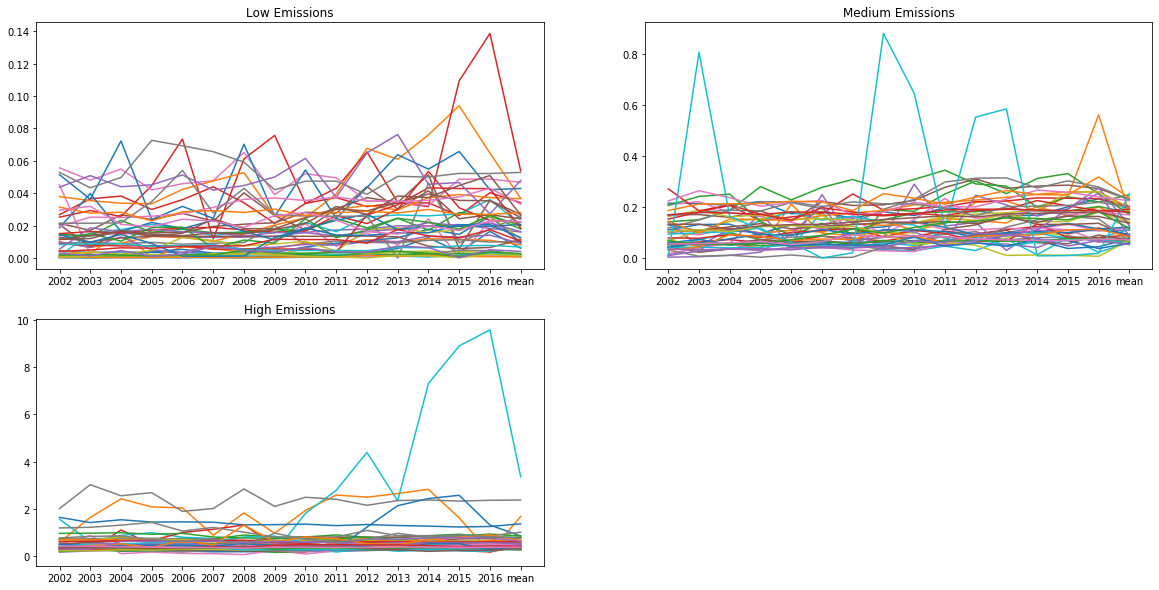

In [311]:
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(2,2,1)
ax1.set_title('Low Emissions')
for x in range(0, emissions_low_2.shape[1]):
    ax1.plot(emissions_low_2.index, emissions_low_2.iloc[:,x])
    
ax2 = figure.add_subplot(2,2,2)
ax2.set_title('Medium Emissions')
for x in range(0, emissions_medium_2.shape[1]):
    ax2.plot(emissions_medium_2.index, emissions_medium_2.iloc[:,x])
    
ax3 = figure.add_subplot(2,2,3)
ax3.set_title('High Emissions')
for x in range(0, emissions_high_2.shape[1]):
    ax3.plot(emissions_high_2.index, emissions_high_2.iloc[:,x])

In [18]:
yield_pca = pd.read_pickle('yield_indic')
yield_pca.head(2)

,Area,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
1,Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243


In [19]:
ferti_year = pd.read_pickle('ferti_year')
ferti_year.head()

,Area,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,11.71,11.71,11.71,14.45,27.58,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.96,2.57,3.02
1,Albania,60.98,52.87,44.13,44.11,49.95,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.19,53.15,54.34
2,Algeria,11.53,11.83,12.25,7.79,7.89,7.51,8.43,5.69,2.75,4.37,5.23,0.49,12.62,2.07,3.42
3,Angola,4.89,4.91,5.32,3.94,3.89,3.28,3.96,2.44,2.21,1.51,1.85,1.03,2.00,0.50,0.81
4,Antigua and Barbuda,8.76,1.70,4.12,6.48,5.34,0.80,0.80,4.60,1.80,0.40,1.80,3.40,0.00,6.60,2.00


## Data frame for fertilizer evolution over the years per country:

In [104]:
ferti_year_2 = ferti_year.T
ferti_year_2.rename(columns=ferti_year_2.loc['Area'], inplace = True)
ferti_year_2.drop(ferti_year_2.index[0], inplace = True)
ferti_year_2.sort_index(inplace = True)
ferti_year_2.head(2)

,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe
2002,3.02,54.34,3.42,0.81,2,18.52,31.98,20.37,117.43,7.63,...,193.8,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,2.57,53.15,2.07,0.5,6.6,24.95,21.15,19.69,205.95,6.1,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


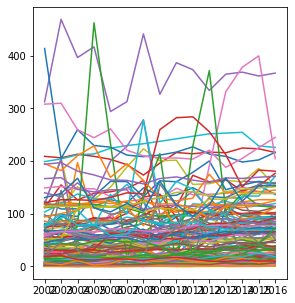

In [76]:
figure = plt.figure(figsize = (10,5))

ax1 = figure.add_subplot(1,2,1)
for x in range(0, ferti_year_2.shape[1]):
    ax1.plot(ferti_year_2.index, ferti_year_2.iloc[:,x])

Text(0.5, 1.0, 'emissions')

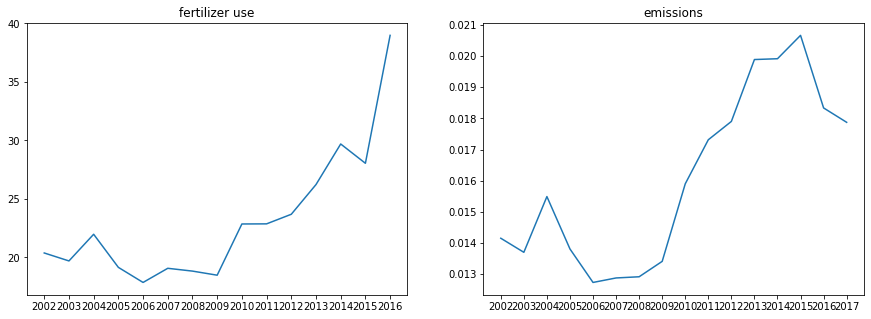

In [77]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'Australia'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'Australia'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

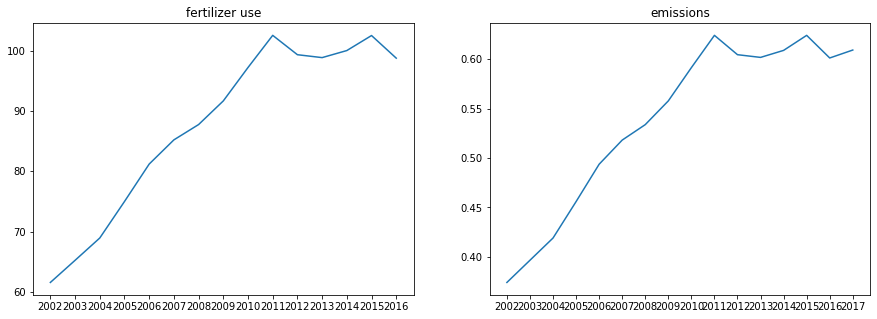

In [78]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'India'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'India'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

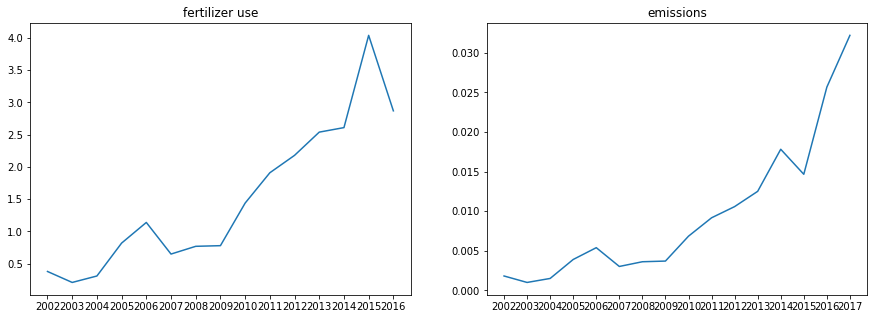

In [79]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(1,2,1)
ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'Burundi'])
ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'Burundi'])
ax2.set_title('emissions')

Text(0.5, 1.0, 'emissions')

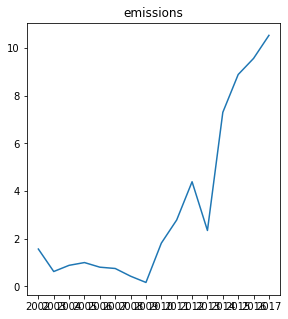

In [115]:
figure = plt.figure(figsize = (10,5))

#ax1 = figure.add_subplot(1,2,1)
#ax1.plot(ferti_year_2.index, ferti_year_2.loc[:,'China, Hong Kong SAR'])
#ax1.set_title('fertilizer use')

ax2 = figure.add_subplot(1,2,2)
ax2.plot(emissions_year_2.index, emissions_year_2.loc[:,'China, Hong Kong SAR'])
ax2.set_title('emissions')

## Checking the correlation between fertilizer use and fertilizer emissions

In [199]:
correlation = pd.merge(emissions_year, ferti_year, left_on = 'area', right_on = 'Area',suffixes=('_emiss','_ferti'))
correlation.drop('Area', axis = 1, inplace = True)

ferti_corr = correlation.iloc[:,~correlation.columns.str.endswith('_emiss')] 
ferti_corr.columns = ferti_corr.columns.str.replace('_ferti', '')


emiss_corr = correlation.iloc[:,~correlation.columns.str.endswith('_ferti')] 
emiss_corr.columns = emiss_corr.columns.str.replace('_emiss', '')


emiss_corr = emiss_corr.T
emiss_corr.rename(columns=emiss_corr.loc['area'], inplace = True)
emiss_corr.columns += '_emiss'
emiss_corr.drop(emiss_corr.index[0], inplace = True)
emiss_corr.sort_index(inplace = True)
emiss_corr = emiss_corr.astype(float)

ferti_corr_2 = ferti_corr.T
ferti_corr_2.rename(columns=ferti_corr_2.loc['area'], inplace = True)
ferti_corr_2.columns += '_ferti'
ferti_corr_2.drop(ferti_corr_2.index[0], inplace = True)
ferti_corr_2.sort_index(inplace = True)
ferti_corr_2 = ferti_corr_2.astype(float)

correlation_2 = pd.merge(emiss_corr, ferti_corr_2, left_index = True, right_index = True)


,area,2017,2016_emiss,2015_emiss,2014_emiss,2013_emiss,2012_emiss,2011_emiss,2010_emiss,2009_emiss,...,2011_ferti,2010_ferti,2009_ferti,2008_ferti,2007_ferti,2006_ferti,2005_ferti,2004_ferti,2003_ferti,2002_ferti
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,...,6.31,4.19,4.45,2.94,3.57,6.20,3.17,2.96,2.57,3.02
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,...,52.74,48.48,48.13,40.39,44.38,42.57,55.94,51.19,53.15,54.34


In [818]:
ferti_corr = correlation.iloc[:,~correlation.columns.str.endswith('_emiss')] 
ferti_corr.columns = ferti_corr.columns.str.replace('_ferti', '')


emiss_corr = correlation.iloc[:,~correlation.columns.str.endswith('_ferti')] 
emiss_corr.columns = emiss_corr.columns.str.replace('_emiss', '')


emiss_corr = emiss_corr.T
emiss_corr.rename(columns=emiss_corr.loc['area'], inplace = True)
emiss_corr.columns += '_emiss'
emiss_corr.drop(emiss_corr.index[0], inplace = True)
emiss_corr.sort_index(inplace = True)
emiss_corr = emiss_corr.astype(float)

ferti_corr_2 = ferti_corr.T
ferti_corr_2.rename(columns=ferti_corr_2.loc['area'], inplace = True)
ferti_corr_2.columns += '_ferti'
ferti_corr_2.drop(ferti_corr_2.index[0], inplace = True)
ferti_corr_2.sort_index(inplace = True)
ferti_corr_2 = ferti_corr_2.astype(float)

matrix = correlation_2.corr()
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.744341,-0.158869,-0.651376,-0.408034,-0.567779,-0.773818,-0.532715,-0.222313,0.154202,-0.700151
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,-0.097419,-0.297085,-0.290858,-0.479220,-0.285641,-0.147521,-0.071401,-0.603313,0.161627,-0.066819


In [819]:
matrix = matrix.iloc[:, ~matrix.columns.str.endswith('_ferti')]
matrix = matrix[~matrix.index.str.endswith('_emiss')]
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_ferti,-0.055915,-0.172949,0.398288,0.480291,-0.163756,0.373306,0.579111,-0.092818,0.423151,0.235039,...,-0.136456,0.302148,0.670223,0.722425,0.447401,0.111683,0.121123,0.115097,0.307212,-0.585470
Albania_ferti,-0.619141,0.135406,-0.149836,-0.355904,-0.361672,-0.192972,-0.081260,0.121774,0.191849,-0.289647,...,0.299017,-0.362860,-0.115946,-0.221617,-0.276869,-0.148765,0.014558,-0.128313,-0.401795,0.067264


In [820]:
ferti_corr_2.head()

,Afghanistan_ferti,Albania_ferti,Algeria_ferti,Angola_ferti,Argentina_ferti,Armenia_ferti,Australia_ferti,Austria_ferti,Azerbaijan_ferti,Bangladesh_ferti,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
2002,3.02,54.34,3.42,0.81,18.52,31.98,20.37,117.43,7.63,123.28,...,193.80,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,2.57,53.15,2.07,0.50,24.95,21.15,19.69,205.95,6.10,109.00,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67
2004,2.96,51.19,12.62,2.00,25.06,26.11,21.97,66.49,9.52,109.37,...,180.81,3.09,67.15,59.09,113.92,78.09,167.42,10.90,20.77,13.23
2005,3.17,55.94,0.49,1.03,18.89,20.30,19.14,70.34,8.51,114.03,...,173.65,2.95,65.63,51.59,113.92,80.16,111.26,2.59,18.70,12.10
2006,6.20,42.57,5.23,1.85,21.97,24.56,17.85,67.27,9.87,126.60,...,164.20,3.45,71.30,67.60,113.92,58.45,103.54,5.48,16.15,14.41


In [821]:
correlation_2 = pd.merge(emiss_corr, ferti_corr_2, left_index = True, right_index = True)
correlation_2.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
2002,0.004193,0.216383,0.004541,0.00031,0.026809,0.072853,0.014153,0.380255,0.021427,0.744678,...,193.80,2.18,62.29,18.27,113.92,78.28,130.52,6.82,15.42,18.86
2003,0.003475,0.215222,0.002762,0.00020,0.036526,0.046711,0.013701,0.668554,0.017086,0.658293,...,197.09,2.59,66.16,46.19,113.92,99.11,138.45,3.29,14.72,20.67


In [822]:
matrix = correlation_2.corr()
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_ferti,United Republic of Tanzania_ferti,United States of America_ferti,Uruguay_ferti,Uzbekistan_ferti,Venezuela (Bolivarian Republic of)_ferti,Viet Nam_ferti,Yemen_ferti,Zambia_ferti,Zimbabwe_ferti
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.744341,-0.158869,-0.651376,-0.408034,-0.567779,-0.773818,-0.532715,-0.222313,0.154202,-0.700151
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,-0.097419,-0.297085,-0.290858,-0.479220,-0.285641,-0.147521,-0.071401,-0.603313,0.161627,-0.066819


In [823]:
matrix = matrix.iloc[:, ~matrix.columns.str.endswith('_ferti')]
matrix.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_emiss,1.000000,0.372315,0.356199,0.594920,0.451509,0.716969,0.457262,0.068265,0.034671,0.305024,...,-0.056722,0.674961,0.366310,0.353643,0.591622,0.045036,0.218114,0.145448,0.790591,-0.043508
Albania_emiss,0.372315,1.000000,-0.025867,-0.124183,0.106277,0.271291,0.052799,0.422417,-0.410688,-0.312498,...,0.483799,-0.051612,-0.029717,-0.321504,-0.044221,-0.397802,0.253677,-0.520217,0.223316,0.271470


In [824]:
matrix = matrix[~matrix.index.str.endswith('_emiss')]#.sort_index()
matrix.head()

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_emiss,United Republic of Tanzania_emiss,United States of America_emiss,Uruguay_emiss,Uzbekistan_emiss,Venezuela (Bolivarian Republic of)_emiss,Viet Nam_emiss,Yemen_emiss,Zambia_emiss,Zimbabwe_emiss
Afghanistan_ferti,-0.055915,-0.172949,0.398288,0.480291,-0.163756,0.373306,0.579111,-0.092818,0.423151,0.235039,...,-0.136456,0.302148,0.670223,0.722425,0.447401,0.111683,0.121123,0.115097,0.307212,-0.585470
Albania_ferti,-0.619141,0.135406,-0.149836,-0.355904,-0.361672,-0.192972,-0.081260,0.121774,0.191849,-0.289647,...,0.299017,-0.362860,-0.115946,-0.221617,-0.276869,-0.148765,0.014558,-0.128313,-0.401795,0.067264
Algeria_ferti,-0.021140,-0.126739,0.779659,0.494117,-0.044297,0.316585,0.608033,-0.231726,0.302065,0.246555,...,-0.000607,0.341930,0.432925,0.406806,0.334738,0.085264,0.306577,0.298703,0.331392,-0.331323
Angola_ferti,0.000016,-0.311862,0.535347,0.667323,-0.165745,0.432912,0.701614,-0.297401,0.429967,0.536584,...,-0.251722,0.534661,0.519014,0.639928,0.621180,0.386052,0.146502,0.330135,0.450183,-0.469092
Argentina_ferti,-0.595201,-0.142542,-0.138445,-0.524665,0.182381,-0.341971,-0.320917,0.110071,0.352070,-0.462121,...,0.147151,-0.487077,-0.033277,-0.241140,-0.515483,-0.254729,-0.249608,0.210983,-0.566726,0.103991


In [825]:
emiss_ferti_corr = pd.DataFrame(correlation.area)

corr_1 = [0]*len(matrix)

for i in range(134):
    corr_1[i] += matrix.iloc[i][i]

corr_2 = pd.DataFrame(corr_1)

emiss_ferti_corr = pd.merge(emiss_ferti_corr, corr_2, left_index = True, right_index = True)
emiss_ferti_corr.rename(columns={"area": "area", "0": "correlation"}, inplace = True)
emiss_ferti_corr.head(2)

,area,0
0,Afghanistan,-0.055915
1,Albania,0.135406


In [826]:
emiss_ferti_corr = pd.merge(emiss_ferti_corr, emissions_class_df, left_on = 'area', right_on = 'area')
emiss_ferti_corr.head(2)

,area,0,mean,emissions_class
0,Afghanistan,-0.055915,0.006103,low
1,Albania,0.135406,0.193822,medium


In [827]:
def ferti_class(x, L): 
    ''' x is the fertilizer value, L is the set of fertilizers values'''
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [828]:
ferti_corr.set_index('area', inplace = True)
ferti_corr = ferti_corr.astype(float)
ferti_corr['mean'] = ferti_corr.mean(axis = 1)
ferti_corr['ferti'] = ferti_corr['mean'].apply(lambda x: ferti_class(x, ferti_corr['mean']))
ferti_class = ferti_corr.loc[:, ['mean', 'ferti']]
emiss_ferti_corr_2 = pd.merge(emiss_ferti_corr, ferti_class, left_on = 'area', right_index = True)

In [829]:
emiss_ferti_corr_2.head(2)

,area,0,mean_x,emissions_class,mean_y,ferti
0,Afghanistan,-0.055915,0.006103,low,7.285248,low
1,Albania,0.135406,0.193822,medium,46.472895,medium


In [809]:
ferti_corr['ferti'] = ferti_corr['mean'].apply(lambda x: ferti_class(x, ferti_corr['mean']))
ferti_class = ferti_corr.loc[:, ['mean', 'ferti']]
ferti_class = ferti_corr.loc[:, ['mean', 'ferti']]

emiss_ferti_corr_2 = pd.merge(emiss_ferti_corr, ferti_class, left_on = 'area', right_index = True)
emiss_ferti_corr_2.head(2)

TypeError: 'DataFrame' object is not callable

In [800]:
ferti_class = ferti_corr.loc[:, ['mean', 'ferti']]

/Users/AmaraSlaymaker/anaconda3/envs/ada/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [443]:
emiss_ferti_corr.head()

,area,0,mean,emissions_class
0,Afghanistan,-0.055915,0.006103,low
1,Albania,0.135406,0.193822,medium
2,Algeria,0.779659,0.008202,low
3,Angola,0.667323,0.001513,low
4,Argentina,0.182381,0.034187,low


In [801]:
emiss_ferti_corr_2 = pd.merge(emiss_ferti_corr, ferti_class, left_on = 'area', right_index = True)
emiss_ferti_corr_2.head(2)

,area,0,mean,ferti
0,Afghanistan,-0.055915,7.285248,NaN
1,Albania,0.135406,46.472895,NaN


In [450]:
low = emiss_ferti_corr_2.query("ferti == 'low'")
low.describe()

,0,mean_x,mean_y
count,44.000000,44.000000,44.000000
mean,0.555566,0.024859,8.227740
std,0.326508,0.024961,5.759157
min,-0.344130,0.000751,0.276293
25%,0.375680,0.003753,3.355481
50%,0.649659,0.017132,7.212893
75%,0.829509,0.034864,13.093632
max,0.969365,0.087360,19.102647


In [451]:
high = emiss_ferti_corr_2.query("ferti == 'high'")
high.describe()

,0,mean_x,mean_y
count,46.000000,46.000000,46.000000
mean,0.453130,0.490349,117.103777
std,0.304920,0.369001,54.733384
min,-0.126260,0.018512,64.465295
25%,0.229361,0.312893,76.636620
50%,0.435286,0.440491,105.365813
75%,0.701081,0.632051,134.226357
max,0.993655,2.376836,345.455499


In [489]:
high = emiss_ferti_corr_2.query("ferti == 'high'")
high.describe()

,0,mean_x,mean_y
count,46.000000,46.000000,46.000000
mean,0.453130,0.490349,117.103777
std,0.304920,0.369001,54.733384
min,-0.126260,0.018512,64.465295
25%,0.229361,0.312893,76.636620
50%,0.435286,0.440491,105.365813
75%,0.701081,0.632051,134.226357
max,0.993655,2.376836,345.455499


<Figure size 1080x360 with 0 Axes>

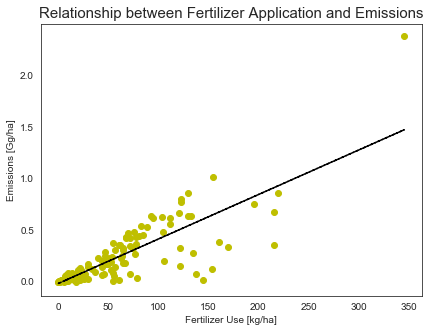

In [672]:
sns.set_style("white")
figure = plt.figure(figsize = (15,5))


ax1 = figure.add_subplot(1,2,1)
coef = np.polyfit(emiss_ferti_corr_2.mean_y,emiss_ferti_corr_2.mean_x,1)
poly1d_fn = np.poly1d(coef)
ax1.set_xlabel('Fertilizer Use [kg/ha]', fontsize = 10)
ax1.set_ylabel('Emissions [Gg/ha]', fontsize = 10)
ax1.set_title('Relationship between Fertilizer Application and Emissions', fontsize = 15)
ax1.grid(alpha=0.5)
plt.plot(emiss_ferti_corr_2.mean_y, emiss_ferti_corr_2.mean_x, 'yo',emiss_ferti_corr_2.mean_y, poly1d_fn(emiss_ferti_corr_2.mean_y), '--k')
plt.grid(None)


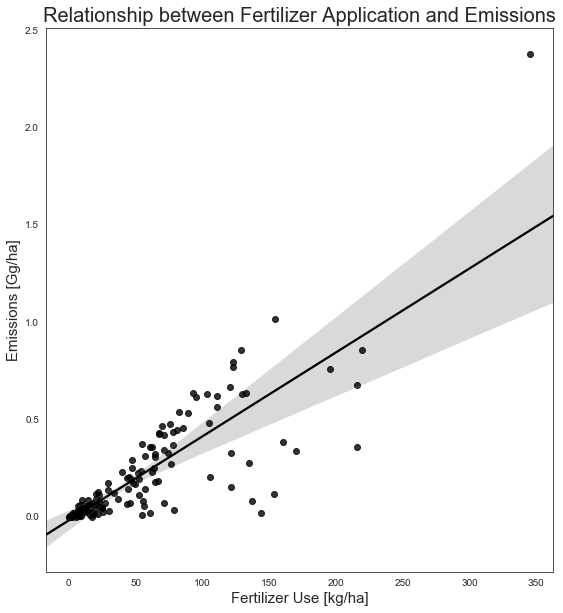

In [700]:
sns.set_style("white")
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(1,2,1)

ax1 = sns.regplot(emiss_ferti_corr_2.mean_y, emiss_ferti_corr_2.mean_x,scatter=True, fit_reg=True, ci=95, color = 'black')
ax1.set_xlabel('Fertilizer Use [kg/ha]', fontsize = 15)
ax1.set_ylabel('Emissions [Gg/ha]', fontsize = 15)
ax1.set_title('Relationship between Fertilizer Application and Emissions', fontsize = 20)

plt.savefig('Fertilizer_Emissions.png')


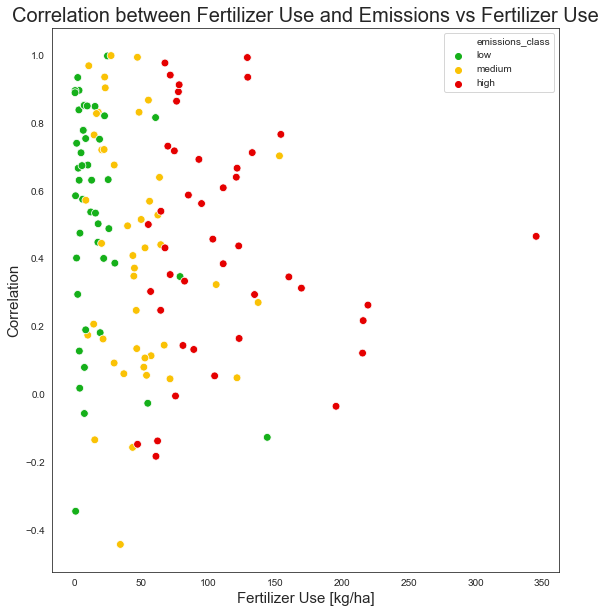

In [713]:
sns.set_style("white")
figure = plt.figure(figsize = (20,10))
colors = ['green','goldenrod','red']

ax1 = figure.add_subplot(1,2,1)
ax1.set_title('Correlation between Fertilizer Use and Emissions vs Fertilizer Use', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(emiss_ferti_corr_2.mean_y, emiss_ferti_corr_2[0], hue='emissions_class', palette=sns.xkcd_palette(colors), data=emiss_ferti_corr_2, s=60)
ax1.set_xlabel('Fertilizer Use [kg/ha]', fontsize = 15)
ax1.set_ylabel('Correlation', fontsize = 15)
plt.grid(None)

plt.savefig('Correlation_Fertilizer.png')

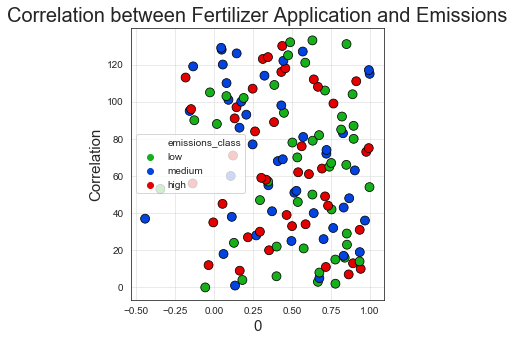

In [620]:
figure = plt.figure(figsize = (10,5))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(1,2,1)
ax1.set_xlabel('Area', fontsize = 15)
ax1.set_ylabel('Correlation', fontsize = 15)
ax1.set_title('Correlation between Fertilizer Application and Emissions', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(emiss_ferti_corr[0], emiss_ferti_corr.index, hue='emissions_class', palette=sns.xkcd_palette(colors), data=emiss_ferti_corr, s=80,edgecolor="black")


In [525]:
emissions_fertilizer.head()

,domain_code,domain,area_code,area,element_code,element,item_code,item,year_code,year,unit,value,flag,flag_description,note,Value,Area,Year,emissions_ha
3,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1961,1961,gigagrams,6.4546,EA,NaN,NaN,37700.0,Afghanistan,1961,0.000171
11,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1962,1962,gigagrams,6.4546,EA,NaN,NaN,37760.0,Afghanistan,1962,0.000171
19,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1963,1963,gigagrams,6.4546,EA,NaN,NaN,37810.0,Afghanistan,1963,0.000171
27,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1964,1964,gigagrams,6.4546,EA,NaN,NaN,37873.0,Afghanistan,1964,0.000170
35,GT,Agriculture Total,2,Afghanistan,7231,Emissions (CO2eq),5061,Synthetic Fertilizers,1965,1965,gigagrams,6.4546,EA,NaN,NaN,37875.0,Afghanistan,1965,0.000170


## Data frame for pca evolution plot:

In [588]:
#yield dataframe
#emissions_fertilizer.rename(columns={'area':'Area'},inplace=True)

pca_emiss_frame=pd.DataFrame(columns=['Area'])
for year in range(2002,2017):
    grouped_yield=(crops.query('`Element Code` == 5419')
    .query('`Year Code` == @year')
    .query('`Item Code` >1000')
    .query('`Area Code` <300')
    .pivot(index='Area',columns='Item',values='Value')
    .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])
    .reset_index()
    )

    grouped_yield['Cereal']=grouped_yield.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)#merge strongly correlated columns
    grouped_yield=grouped_yield.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    grouped_yield=grouped_yield.dropna(axis=0)
    grouped_yield=grouped_yield.reset_index()
    grouped_yield.drop(columns=['index'],inplace=True)
    
    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])
    grouped_yield_pca.rename(columns={'PC1':str(year)},inplace=True)
    pca_emiss_frame=pca_emiss_frame.merge(grouped_yield_pca.loc[:,['Area',str(year)]], on='Area',how='outer')
    
    emissions=(emissions_fertilizer
            .query('`year_code` == @year')
            .pivot(index='Area',columns = 'item_code',values='emissions_ha')
            .dropna(axis=0)
            .reset_index()
              )
    emissions.rename(columns={5061:str(year)+'_emiss'},inplace=True)
    emissions.dropna(axis=0, inplace=True)
    emissions['emiss_color_'+str(year)]=emissions[str(year)+'_emiss'].apply(lambda x: emissions_color(x, emissions[str(year)+'_emiss']))
    pca_emiss_frame=pca_emiss_frame.merge(emissions.loc[:,['Area', str(year)+'_emiss','emiss_color_'+str(year)]], on = 'Area', how='left')
pca_emiss_frame.head(5)

,Area,2002,2002_emiss,emiss_color_2002,2003,2003_emiss,emiss_color_2003,2004,2004_emiss,emiss_color_2004,...,emiss_color_2013,2014,2014_emiss,emiss_color_2014,2015,2015_emiss,emiss_color_2015,2016,2016_emiss,emiss_color_2016
0,Afghanistan,-0.814322,0.004193,green,-0.815293,0.003475,green,-0.905765,0.003804,green,...,green,-1.149030,0.012578,green,-1.260170,0.003588,green,-1.359291,0.016459,green
1,Albania,0.462978,0.216383,red,0.168131,0.215222,yellow,0.062443,0.207790,yellow,...,yellow,1.250716,0.168811,yellow,1.277543,0.202296,yellow,1.374337,0.234306,yellow
2,Algeria,-0.778872,0.004541,green,-0.376293,0.002762,green,-0.516225,0.016428,green,...,green,0.202174,0.011918,green,0.281118,0.011584,green,0.287093,0.010955,green
3,Angola,-1.741561,0.000310,green,-1.747918,0.000200,green,-1.918447,0.000806,green,...,green,-1.543238,0.003011,green,-1.591230,0.002780,green,-1.626394,0.002266,green
4,Argentina,1.903843,0.026809,green,2.196640,0.036526,yellow,1.604389,0.038264,yellow,...,green,1.449124,0.034035,green,1.527095,0.026195,green,1.363239,0.040350,green


## Data frame for pca vs emissions plots 

In [590]:
same_group_countries=pca_emiss_frame.loc[:,['Area','emiss_color_2002']]
same_group_countries.rename(columns={"emiss_color_2002": "group"}, inplace=True)
print(same_group_countries.shape[0])
for year in range (2002,2016+1,1):
    search= 'emiss_color_'+str(year)
    to_intersect = pca_emiss_frame.loc[:,['Area','emiss_color_'+str(year)]]
    to_intersect.rename(columns={'emiss_color_'+str(year): "group"}, inplace=True)
    same_group_countries=pd.merge(same_group_countries, to_intersect)
print(same_group_countries.shape[0])

167
101


In [592]:
high_sample=same_group_countries.query('group == "red"').sample(n=29).Area
low_sample=same_group_countries.query('group == "green"').sample(n=13).Area
med_sample=same_group_countries.query('group == "yellow"').sample(n=13).Area

In [599]:
emissions_year.rename(columns={'area':'Area'},inplace=True)
emissions_year.head()

,Area,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
1,Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383
2,Algeria,0.010962,0.010955,0.011584,0.011918,0.009971,0.011320,0.008780,0.009376,0.005787,0.003610,0.005731,0.006873,0.000640,0.016428,0.002762,0.004541
3,Angola,0.002912,0.002266,0.002780,0.003011,0.002229,0.002125,0.001792,0.001920,0.001159,0.000914,0.000625,0.000744,0.000413,0.000806,0.000200,0.000310
5,Argentina,0.042359,0.040350,0.026195,0.034035,0.034097,0.031781,0.037313,0.033754,0.021415,0.034092,0.043978,0.036031,0.029998,0.038264,0.036526,0.026809


In [601]:
high_yield = yield_pca[yield_pca.Area.isin(high_sample.values)]
high_emiss = emissions_year[emissions_year.Area.isin(high_sample.values)]
high_yield=high_yield.set_index('Area').T
high_emiss=high_emiss.set_index('Area').T
high_values = pd.merge(high_emiss,high_yield, left_index=True, right_index=True, suffixes=('_emiss', '_pca')) 

med_yield = yield_pca[yield_pca.Area.isin(med_sample.values)]
med_emiss = emissions_year[emissions_year.Area.isin(med_sample.values)]
med_yield=med_yield.set_index('Area').T
med_emiss=med_emiss.set_index('Area').T
med_values = pd.merge(med_emiss,med_yield, left_index=True, right_index=True, suffixes=('_ferti', '_pca')) 

low_yield = yield_pca[yield_pca.Area.isin(low_sample.values)]
low_emiss = emissions_year[emissions_year.Area.isin(low_sample.values)]
low_yield=low_yield.set_index('Area').T
low_emiss=low_emiss.set_index('Area').T
low_values = pd.merge(low_emiss,low_yield, left_index=True, right_index=True, suffixes=('_ferti', '_pca')) 


In [602]:
high_values.head(2)

Area,Bangladesh_emiss,"China, Taiwan Province of_emiss",Croatia_emiss,Cyprus_emiss,Czechia_emiss,Denmark_emiss,Finland_emiss,France_emiss,Germany_emiss,Hungary_emiss,...,Poland_pca,Republic of Korea_pca,Slovakia_pca,Slovenia_pca,Sri Lanka_pca,Suriname_pca,Sweden_pca,Trinidad and Tobago_pca,United Kingdom_pca,Viet Nam_pca
2016,0.822994,1.257897,0.276540,0.458453,0.747740,0.560756,0.391898,0.492611,0.583753,0.424942,...,0.559988,0.482263,0.434243,0.542338,0.212155,0.340847,0.648150,0.138051,0.769318,0.319417
2015,0.930580,1.238742,0.334311,0.400452,0.733649,0.551426,0.407366,0.503270,0.599295,0.414454,...,0.462536,0.465199,0.395538,0.535559,0.200034,0.323987,0.618979,0.220503,0.770704,0.307230


In [603]:
low_values.head(2)

Area,Algeria_ferti,Angola_ferti,Bhutan_ferti,Burundi_ferti,Gabon_ferti,Ghana_ferti,Guinea_ferti,Kyrgyzstan_ferti,Libya_ferti,Mozambique_ferti,...,Burundi_pca,Gabon_pca,Ghana_pca,Guinea_pca,Kyrgyzstan_pca,Libya_pca,Mozambique_pca,Saudi Arabia_pca,Senegal_pca,United Republic of Tanzania_pca
2016,0.010955,0.002266,0.009846,0.025675,0.004584,0.025952,0.002842,0.021564,0.006560,0.00248,...,0.149823,0.098825,0.154511,0.041609,0.293625,0.242739,0.060598,0.472282,0.148608,0.088646
2015,0.011584,0.002780,0.011302,0.014661,0.004853,0.017547,0.001074,0.020040,0.005887,0.00156,...,0.091157,0.091150,0.152348,0.037134,0.274372,0.226515,0.052066,0.443109,0.141082,0.082580


In [604]:
med_values.head(2)

Area,Brazil_ferti,Chile_ferti,Colombia_ferti,Dominican Republic_ferti,Honduras_ferti,Nicaragua_ferti,Papua New Guinea_ferti,Peru_ferti,Republic of Moldova_ferti,Ukraine_ferti,...,Dominican Republic_pca,Honduras_pca,Nicaragua_pca,Papua New Guinea_pca,Peru_pca,Republic of Moldova_pca,Ukraine_pca,United States of America_pca,Uzbekistan_pca,Venezuela (Bolivarian Republic of)_pca
2016,0.119425,0.108117,0.081764,0.115330,0.181342,0.075765,0.113928,0.078839,0.255428,0.183570,...,0.305150,0.384243,0.341894,0.235245,0.311507,0.231106,0.444410,0.813075,0.674764,0.245610
2015,0.096348,0.134516,0.083862,0.137195,0.144343,0.071334,0.112184,0.078042,0.193982,0.151029,...,0.282699,0.366760,0.347845,0.229623,0.297409,0.147519,0.365077,0.757178,0.644127,0.233933


yield_pca_2 = yield_pca.T
yield_pca_2.rename(columns=yield_pca_2.loc['Area'], inplace = True)
yield_pca_2.drop(yield_pca_2.index[0], inplace = True)
yield_pca_2.sort_index(inplace = True)
yield_pca_2.dropna(axis = 'columns', inplace = True)
yield_pca_2.head()

In [216]:
pca = emiss_pca.iloc[:,~emiss_pca.columns.str.endswith('_emiss')] 
pca.columns = pca.columns.str.replace('_pca', '')

emiss = emiss_pca.iloc[:,~emiss_pca.columns.str.endswith('_pca')] 
emiss.columns = pca.columns.str.replace('_emiss', '')


emiss = emiss.T
emiss.rename(columns=emiss.loc['Area'], inplace = True)
emiss.columns += '_emiss'
emiss.drop(emiss.index[0], inplace = True)
emiss.sort_index(inplace = True)

pca = pca.T
pca.rename(columns=pca.loc['Area'], inplace = True)
pca.columns += '_pca'
pca.drop(pca.index[0], inplace = True)
pca.sort_index(inplace = True)

## Final Data Frame:

In [222]:
emiss_pca_df = pd.merge(emiss, pca, left_index = True, right_index = True)
emiss_pca_df.head(2)

,Afghanistan_emiss,Albania_emiss,Algeria_emiss,Angola_emiss,Argentina_emiss,Armenia_emiss,Australia_emiss,Austria_emiss,Azerbaijan_emiss,Bangladesh_emiss,...,United Kingdom_pca,United Republic of Tanzania_pca,United States of America_pca,Uruguay_pca,Uzbekistan_pca,Venezuela (Bolivarian Republic of)_pca,Viet Nam_pca,Yemen_pca,Zambia_pca,Zimbabwe_pca
2002,0.0239688,0.216326,0.010962,0.00291201,0.0423586,0.346791,0.0178737,0.278032,0.0117141,0.871482,...,0.878847,0.144382,0.789424,0.341718,0.383109,0.386638,0.30421,0.222389,0.131673,0.100226
2003,0.0164594,0.234306,0.0109554,0.00226551,0.0403497,0.563134,0.0183354,0.284856,0.0356616,0.822994,...,0.879722,0.032286,0.795847,0.353248,0.341305,0.364923,0.278476,0.161158,0.0685054,0.0620404


## Data frame for efficiency

In [830]:
emissions_year_ee = emissions_year.set_index('area')
emissions_year_ee.astype(float)
emissions_year_ee.head(2)

,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
area,,,,,,,,,,,,,,,,
Afghanistan,0.023969,0.016459,0.003588,0.012578,0.005943,0.002906,0.003911,0.002201,0.002410,0.002457,0.002788,0.003484,0.003485,0.003804,0.003475,0.004193
Albania,0.216326,0.234306,0.202296,0.168811,0.166962,0.187756,0.198276,0.168136,0.182362,0.157102,0.181606,0.174816,0.223010,0.207790,0.215222,0.216383


In [831]:
yield_pca_ee = yield_pca.set_index('Area')
yield_pca_ee.astype(float)
yield_pca_ee.head(2)

,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Area,,,,,,,,,,,,,,,
Afghanistan,0.263494,0.208613,0.192926,0.179725,0.191971,0.182814,0.162389,0.155492,0.134034,0.143281,0.172716,0.193963,0.171989,0.161094,0.159547
Albania,0.394228,0.319205,0.295479,0.332666,0.371833,0.345489,0.371913,0.371373,0.418766,0.428709,0.446074,0.447650,0.447010,0.440241,0.472243


In [838]:
ee = yield_pca.copy()

years = np.array([range(2002,2017)]).astype(str)

for x in years:
    year = x
    ee[year]= yield_pca[year] /  emissions_year[year]

ee = ee.T
ee.rename(columns=ee.loc['Area'], inplace = True)
ee.drop(ee.index[0], inplace = True)
ee.sort_index(inplace = True)
ee.dropna(axis = 1, inplace = True)
ee['mean'] = ee.mean(axis=1)
ee.head(2)

,Afghanistan,Albania,Algeria,Angola,Armenia,Australia,Austria,Azerbaijan,Bahamas,Barbados,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,mean
2002,62.8446,1.8219,58.8309,543.699,14.0672,6.91644,53.5291,0.828021,14.7792,0.479504,...,0.335747,188.481,1.99799,34.0695,2.89817,5.34311,0.286851,42.7057,8.70643,65.041750
2003,60.0405,1.48314,93.4038,517.934,8.64511,8.58017,51.1229,0.446329,15.733,0.147411,...,0.0753898,158.911,1.95931,11.974,2.71709,4.84016,0.191846,50.7037,5.14283,120.593473


In [837]:
ee = ee.T
ee.rename(columns=ee.loc['Area'], inplace = True)
ee.drop(ee.index[0], inplace = True)
ee.sort_index(inplace = True)
ee.dropna(axis = 1, inplace = True)
ee.head()

KeyError: 'Area'

## Data set of "efficiency"
(I didvided PCA1 by "emissions-ha")

In [471]:
ee['mean'] = ee.mean(axis=1)
ee.head(5)

,Afghanistan,Albania,Algeria,Angola,Armenia,Australia,Austria,Azerbaijan,Bahamas,Barbados,...,United Republic of Tanzania,United States of America,Uruguay,Uzbekistan,Venezuela (Bolivarian Republic of),Viet Nam,Yemen,Zambia,Zimbabwe,mean
2002,62.8446,1.8219,58.8309,543.699,14.0672,6.91644,53.5291,0.828021,14.7792,0.479504,...,0.335747,188.481,1.99799,34.0695,2.89817,5.34311,0.286851,42.7057,8.70643,65.041750
2003,60.0405,1.48314,93.4038,517.934,8.64511,8.58017,51.1229,0.446329,15.733,0.147411,...,0.0753898,158.911,1.95931,11.974,2.71709,4.84016,0.191846,50.7037,5.14283,120.593473
2004,50.7232,1.42201,14.2557,106.344,9.34631,7.73449,48.5803,1.24395,9.44165,0.0879983,...,0.119536,122.401,1.73041,9.3708,2.57492,4.1942,0.223894,15.1848,4.16473,67.470883
2005,51.5769,1.49171,378.171,225.826,14.7243,10.6327,53.1368,1.30624,10.4891,0.103415,...,0.111983,126.548,1.99249,11.5543,2.28622,4.13689,0.276478,72.5758,2.08809,87.737119
2006,55.0989,2.12699,36.9763,127.792,11.4044,2.21188,59.5549,1.41094,9.62907,0.113769,...,0.152292,115.008,2.20619,10.3735,2.37393,5.49358,0.36121,31.9503,3.14053,123.950218


In [606]:
ee_sampled = ee.sample(n=50, axis = 1)
ee_sampled.head()

,Spain,Greece,Belize,Canada,Estonia,Eswatini,Albania,Philippines,Eritrea,Algeria,...,Croatia,Nigeria,Sierra Leone,Mongolia,Madagascar,Portugal,Ukraine,Finland,Trinidad and Tobago,Bhutan
2002,1.11348,12.1758,1.72403,195.977,0.176009,0.979771,1.8219,7.2386,0.649874,58.8309,...,10.0785,3.49626,18.1249,0,1.94034,6.38076,4.22404,23.2335,38.5768,0.288967
2003,1.06236,22.5584,1.30371,350.193,0.0818167,0.495514,1.48314,3.93878,0.0187667,93.4038,...,6.12327,1.97552,8.68325,0,1.20188,6.06215,3.91491,60.6438,0.201608,0.158155
2004,1.05077,13.2317,1.00193,241.326,0.0684061,0.49142,1.42201,1.74138,0,14.2557,...,7.72428,2.12883,7.8188,0.282782,0.969903,5.86842,4.82457,21.9149,1.00557,1.62495
2005,0.971236,8.19068,1.08633,98.3775,0.107426,0.259906,1.49171,1.92306,0.123814,378.171,...,5.85957,2.11433,9.43207,0.516335,1.32388,8.90551,4.68739,27.6905,1.32509,1.02426
2006,1.14389,9.09355,0.824449,73.7828,0.132249,0.34269,2.12699,2.49111,0.113034,36.9763,...,5.99211,1.97963,9.02122,2.10887,1.13787,9.13493,4.09365,25.5309,2.43156,1.50638


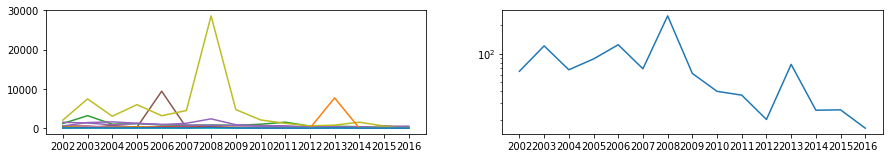

In [609]:
figure = plt.figure(figsize = (15,5))

ax1 = figure.add_subplot(2,2,1)
for x in range(0, ee.shape[1]):
    ax1.plot(ee.index, ee.iloc[:,x])

ax1.set_titl

ax2 = figure.add_subplot(2,2,2)
ax2.set_yscale('log')
ax2.semilogy(ee.index, ee['mean'])

/Users/AmaraSlaymaker/anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


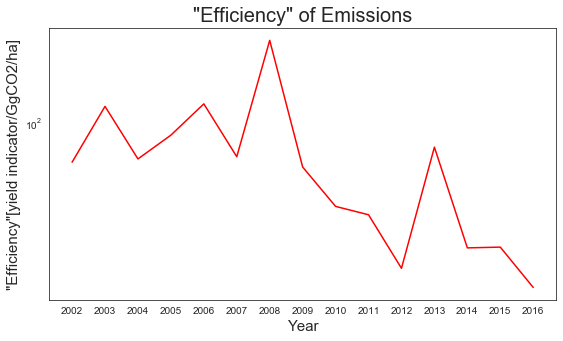

In [714]:
figure = plt.figure(figsize = (20,5))
ax1 = figure.add_subplot(1,2,1)

ax1 = figure.add_subplot(1,2,1)
ax1.set_yscale('log')
ax1 = sns.lineplot(ee.index, ee['mean'], color = 'red')
ax1.set_title('"Efficiency" of Emissions', size = 20)
ax1.set_ylabel('"Efficiency"[yield indicator/GgCO2/ha]', size = 15)
ax1.set_xlabel('Year', size = 15)

plt.savefig('average_efficiency.png')

In [503]:
ee.loc['2008',:].sort_values(ascending = False)

Netherlands          28630
Norway             2376.63
Germany            804.032
Morocco            759.249
Kenya              408.799
                   ...    
Congo            0.0719162
Côte d'Ivoire    0.0578006
Gambia           0.0281195
Eritrea          0.0231991
Mauritania               0
Name: 2008, Length: 141, dtype: object

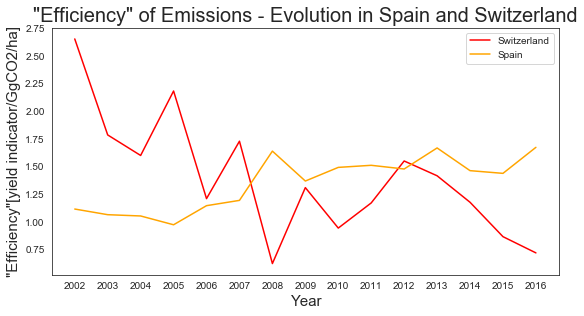

In [716]:
figure = plt.figure(figsize = (20,10))

ax1 = figure.add_subplot(2,2,1)
ax1.plot(ee.index, ee['Switzerland'], color = 'red')
ax1.plot(ee.index, ee['Spain'], color = 'orange')
ax1.legend(['Switzerland','Spain'])
ax1.set_title('"Efficiency" of Emissions - Evolution in Spain and Switzerland', size = 20)
ax1.set_ylabel('"Efficiency"[yield indicator/GgCO2/ha]', size = 15)
ax1.set_xlabel('Year', size = 15)

plt.savefig('efficiency_examples.png')

## END

In [746]:
def emissions_class_2(x, L): 
    ''' x is the emissions value, L is the set of emissions values'''
    if x<np.percentile(L,33):
        return 0
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 1
    else:
        return 2

In [732]:
crops.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F
1,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1976,1976,ha,5900,F


In [734]:
#Prepare the yield dataset for umap dimensional reduction analysis:

grouped_yield = crops.query('`Element Code` == 5419').query('`Item Code` >1000')
grouped_yield = crops.groupby(['Item','Year']).sum()

grouped_yield_2016=(crops.query('`Element Code` == 5419') #by yield
        .query('`Year Code` == 2016') 
        .query('`Item Code` >1000') #grouped crops
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0)
        .reset_index()
          )
grouped_yield_2016.head(2)

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19391.0,19816.0,83127.0,16667.0,3727.681319,88201.0,6868.32967,4060.164835,7406.0,119868.0,15984.0,91869.0
1,Africa,14245.0,15261.0,108260.0,13007.0,0.000000,88514.0,0.00000,0.000000,7629.0,85875.0,5437.0,83707.0


In [735]:
yield_2016 = grouped_yield_2016.drop('Area',axis=1).values

#Normalization 
from sklearn import preprocessing

x = yield_2016
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
yield_2016 = pd.DataFrame(x_scaled)

For a first analysis, we will look at the year 2016 - therefore we will first isolate the emissions from this year, starting with all emissions:

In [736]:
emissions_2016 = total_emissions.query('year == 2016').groupby('area').sum()
emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,18,65079,45560,18144,18144,13832.9964,0.0,341190.0,18144,0.364890
Albania,27,65079,47259,18144,18144,2924.0750,0.0,10635.3,18144,2.474465


Next we apply umap to the data and classify in terms of emissions:

In [747]:
import umap

reducer = umap.UMAP(random_state=1)
embedding = reducer.fit_transform(yield_2016)
embedding2=pd.DataFrame(embedding)
embedding2=pd.merge(embedding2,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2=pd.merge(embedding2,emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2['emissions_class']=embedding2.emissions_ha.apply(lambda x: emissions_class(x, embedding2.emissions_ha))
embedding2['emissions_class2']=embedding2.emissions_ha.apply(lambda x: emissions_class_2(x, embedding2.emissions_ha))
embedding2.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,-0.977878,3.675343,Afghanistan,0.364890,low,0
2,-2.673802,2.858271,Albania,2.474465,high,2


Finally we visualize the umap results and the distribution with respect to each emissions class.

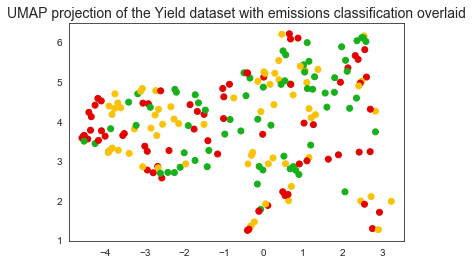

In [748]:
#Visualize 
plt.scatter(embedding2[0], embedding2[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2.emissions_class2.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with emissions classification overlaid', fontsize=14);

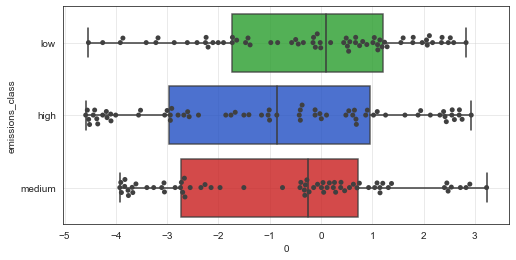

In [751]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
#cmap = sns.cubehelix_palette(rot=-.4)
ax = sns.boxplot(x=embedding2[0], y='emissions_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[0], y='emissions_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

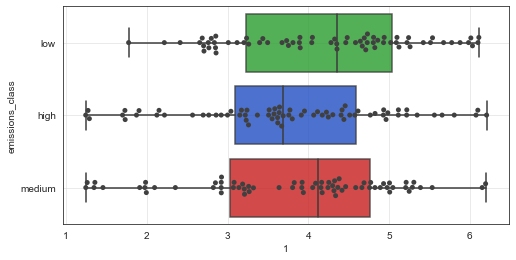

In [752]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))
#sns.palplot(sns.cubehelix_palette(3))
colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2[1], y='emissions_class', data=embedding2, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2[1], y='emissions_class', data=embedding2, color=".25")
ax.grid(alpha=0.5)

In [753]:
fert_emissions_2016 = total_emissions.query("item == 'Synthetic Fertilizers'").query('year == 2016').groupby('area').sum()
fert_emissions_2016.head(2)

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Afghanistan,2,7231,5061,2016,2016,623.9758,0.0,37910.0,2016,0.016459
Albania,3,7231,5061,2016,2016,276.8789,0.0,1181.7,2016,0.234306


In [755]:
#perform a new umap analysis
reducer_new = umap.UMAP(random_state=1)
embedding_new = reducer_new.fit_transform(yield_2016)
embedding2_new=pd.DataFrame(embedding_new)
embedding2_new=pd.merge(embedding2_new,grouped_yield_2016['Area'], left_index=True, right_index=True)
embedding2_new=pd.merge(embedding2_new,fert_emissions_2016.loc[:,['emissions_ha']],left_on='Area',right_index = True)
embedding2_new['emissions_class']=embedding2_new.emissions_ha.apply(lambda x: emissions_class(x, embedding2_new.emissions_ha))
embedding2_new['emissions_class2']=embedding2_new.emissions_ha.apply(lambda x: emissions_class_2(x, embedding2_new.emissions_ha))
embedding2_new.head(2)

,0,1,Area,emissions_ha,emissions_class,emissions_class2
0,-0.977878,3.675343,Afghanistan,0.016459,low,0
2,-2.673802,2.858271,Albania,0.234306,medium,1


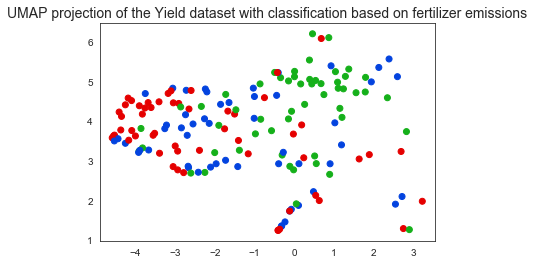

In [756]:
plt.scatter(embedding2_new[0], embedding2_new[1], c=[sns.xkcd_palette(colors)[x] for x in embedding2_new.emissions_class2.values])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Yield dataset with classification based on fertilizer emissions', fontsize=14);

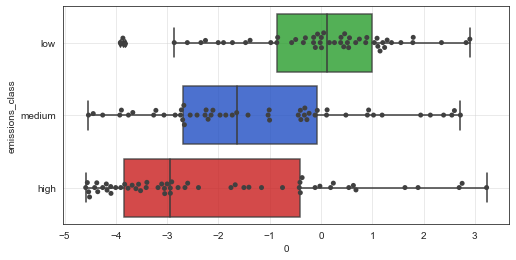

In [757]:
#Box plot x axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[0], y='emissions_class', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[0], y='emissions_class', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

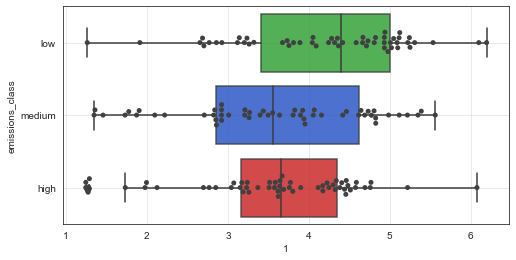

In [759]:
#Box plot y axis
fig = plt.figure(figsize = (8,4))

colors = ["green", "blue", "red"]
ax = sns.boxplot(x=embedding2_new[1], y='emissions_class', data=embedding2_new, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax = sns.swarmplot(x=embedding2_new[1], y='emissions_class', data=embedding2_new, color=".25")
ax.grid(alpha=0.5)

For example, inspecting the "low" emissions group, we find that Australia has synthetic fertilizer emissions in the low range, but has yield characteristics more similar to that of countries with medium to high emissions such as spain:

In [760]:
embedding2_new.query("Area == ['Australia','Spain']")

,0,1,Area,emissions_ha,emissions_class,emissions_class2
11,-2.251897,2.703403,Australia,0.018335,low,0
207,-1.967824,2.921457,Spain,0.241359,medium,1


Let's take a closer look at the data we have for emissions and crop yields of these countries:

In [761]:
fert_emissions_2016.query("area == ['Australia','Spain']")

,area_code,element_code,item_code,year_code,year,value,note,Value,Year,emissions_ha
area,,,,,,,,,,
Australia,10,7231,5061,2016,2016,6803.8569,0.0,371078.0,2016,0.018335
Spain,203,7231,5061,2016,2016,6339.4598,0.0,26265.7,2016,0.241359


In [762]:
grouped_yield_2016.query("Area == ['Australia','Spain']")

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
11,Australia,20698.0,20752.0,199756.0,22375.0,19910.230769,142540.0,8784.659341,4921.505495,11965.0,401728.0,17488.0,258512.0
207,Spain,38179.0,38625.0,239620.0,39736.0,5728.000000,122106.0,6009.054945,5716.241758,13873.0,309510.0,3796.0,391402.0
